In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
from zipfile import ZipFile
filename="HAM10000.zip"
with ZipFile(filename,'r') as zip:
  zip.extractall()
  print("done")


done


In [2]:
# %pip install pandas numpy tensorflow scikit-learn
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import cv2
from keras import backend as K
from keras.layers import Layer,InputSpec
import keras.layers as kl
from glob import glob
from sklearn.metrics import roc_curve, auc
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from sklearn.metrics import roc_auc_score
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from  matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.layers import concatenate,Dense, Conv2D, MaxPooling2D, Flatten,Input,Activation,add,AveragePooling2D,BatchNormalization,Dropout
%matplotlib inline
import shutil
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report ,confusion_matrix
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

2024-08-02 19:34:27.446009: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Duplicate key in file PosixPath('/home/vinay/miniconda3/envs/tensorflow/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'), line 789 ('toolbar: toolmanager')
/tmp/ipykernel_3318/262088509.py:17: UserWarning: Treat the new Tool classes introduced in v1.5 as experimental for now; the API and rcParam may change in future versions.
  from  matplotlib import pyplot as plt


In [3]:
data_pd = pd.read_csv('HAM10000_metadata.csv')
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
train_dir = os.path.join('.', 'train_dir')
test_dir = os.path.join('.', 'test_dir')

In [5]:
df_count = data_pd.groupby('lesion_id').count()
df_count.head()

,image_id,dx,dx_type,age,sex,localization
lesion_id,,,,,,
HAM_0000000,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1


In [6]:
df_count = df_count[df_count['dx'] == 1]
df_count.reset_index(inplace=True)

In [7]:
def duplicates(x):
    unique = set(df_count['lesion_id'])
    if x in unique:
        return 'no'
    else:
        return 'duplicates'

In [8]:
data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates


In [9]:
df_count = data_pd[data_pd['is_duplicate'] == 'no']

In [10]:
train, test_df = train_test_split(df_count, test_size=0.15, stratify=df_count['dx'])

In [11]:
def identify_trainOrtest(x):
    test_data = set(test_df['image_id'])
    if str(x) in test_data:
        return 'test'
    else:
        return 'train'

#creating train_df
data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']
train_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate,train_test_split
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,duplicates,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,duplicates,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,duplicates,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,duplicates,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,duplicates,train


In [12]:
test_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,is_duplicate
518,HAM_0001979,ISIC_0027527,bkl,histo,55.0,male,face,no
4322,HAM_0000470,ISIC_0026965,nv,follow_up,50.0,female,foot,no
9178,HAM_0007208,ISIC_0030159,nv,histo,75.0,female,upper extremity,no
4761,HAM_0002048,ISIC_0029137,nv,follow_up,70.0,male,lower extremity,no
5660,HAM_0003526,ISIC_0027070,nv,follow_up,30.0,male,trunk,no


In [13]:
# Image id of train and test images
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

In [14]:
len(test_list)

828

In [15]:
len(train_list)

9187

In [16]:
# Set the image_id as the index in data_pd
data_pd.set_index('image_id', inplace=True)

In [ ]:
os.mkdir(train_dir)
os.mkdir(test_dir)

In [17]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

In [20]:
for i in targetnames:
  directory1=train_dir+'/'+i
  directory2=test_dir+'/'+i
  os.mkdir(directory1)
  os.mkdir(directory2)

In [21]:
for image in train_list:
    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image
    if (os.path.exists(os.path.join('./HAM10000_images_part_1', file_name))):
        source = os.path.join('./HAM10000_images_part_1', file_name)
    elif (os.path.exists(os.path.join('./HAM10000_images_part_2', file_name))):
        source = os.path.join('./HAM10000_images_part_2', file_name)
    else:
        raise Exception('Error in Path: '+file_name)

    # copying the image from the source to target file
    target = os.path.join(train_dir, label, file_name)

    shutil.copyfile(source, target)

In [22]:
for image in test_list:

    file_name = image+'.jpg'
    label = data_pd.loc[image, 'dx']

    # path of source image
    if (os.path.exists(os.path.join('./HAM10000_images_part_1', file_name))):
        source = os.path.join('./HAM10000_images_part_1', file_name)
    elif (os.path.exists(os.path.join('./HAM10000_images_part_2', file_name))):
        source = os.path.join('./HAM10000_images_part_2', file_name)
    else:
        raise Exception('Error in Path: '+file_name)

    # copying the image from the source to target file
    target = os.path.join(test_dir, label, file_name)

    shutil.copyfile(source, target)

In [23]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Augmenting images and storing them in temporary directories
for img_class in targetnames:
    print(img_class)

    #creating temporary directories
    # creating a base directory
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    # creating a subdirectory inside the base directory for images of the same class
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_list = os.listdir('./train_dir/' + img_class)

    # Copy images from the class train dir to the img_dir
    for file_name in img_list:

        # path of source image in training directory
        source = os.path.join('./train_dir/' + img_class, file_name)

        # creating a target directory to send images
        target = os.path.join(img_dir, file_name)

        # copying the image from the source to target file
        shutil.copyfile(source, target)

    # Temporary augumented dataset directory.
    source_path = aug_dir

    # Augmented images will be saved to training directory
    save_path = './train_dir/' + img_class

    # Creating Image Data Generator to augment images
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(

        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'

    )

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(source_path,save_to_dir=save_path,save_format='jpg',target_size=(299, 299),batch_size=batch_size)

    # Generate the augmented images
    aug_images = 8000

    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((aug_images - num_files) / batch_size))

    # creating 8000 augmented images per class
    for i in range(0, num_batches):
        images, labels = next(aug_datagen)

    # delete temporary directory
    shutil.rmtree('aug_dir')


akiec
Found 304 images belonging to 1 classes.


bcc
Found 488 images belonging to 1 classes.
bkl
Found 1033 images belonging to 1 classes.
df
Found 109 images belonging to 1 classes.
mel
Found 1079 images belonging to 1 classes.
nv
Found 6042 images belonging to 1 classes.
vasc
Found 132 images belonging to 1 classes.


In [18]:
train_path = './train_dir'
test_path = './test_dir'
batch_size = 16

In [19]:
datagen=ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)

In [20]:
image_size = 299
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)

print("\nTest Batches: ")
test_batches =datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=batch_size,
                                           shuffle=False)


Train Batches: 
Found 51699 images belonging to 7 classes.

Test Batches: 
Found 828 images belonging to 7 classes.


In [21]:

irv2 = tf.keras.applications.InceptionResNetV2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classifier_activation="softmax",

)

# Exclude the last 28 layers of the model.
conv = irv2.layers[-28].output


2024-08-02 19:35:11.132770: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-02 19:35:12.996470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-02 19:35:13.002092: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [22]:


conv  = Activation('relu')(conv)
conv = Dropout(0.5)(conv)


In [23]:

output = Flatten()(conv)
output = Dense(7, activation='softmax')(output)
model = Model(inputs=irv2.input, outputs=output)

In [24]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [25]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.1)
model.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [26]:
# from google.colab import files
class_weights = {
                    0: 1.0,  # akiec
                    1: 1.0,  # bcc
                    2: 1.0,  # bkl
                    3: 1.0,  # df
                    4: 5.0,  # mel
                    5: 1.0,  # nv
                    6: 1.0,  # vasc
                }



checkpoint = ModelCheckpoint(filepath = 'saved_model.keras',monitor='val_accuracy',save_best_only=True)



In [28]:
Earlystop = EarlyStopping(monitor='val_loss', mode='min',patience=30, min_delta=0.001)
model = tf.keras.saving.load_model('saved_model.keras')
history = model.fit(train_batches,
                    steps_per_epoch=int(len(train_df)//10),
                    epochs=150,
                    verbose=2,
                    validation_data=test_batches,validation_steps=int(len(test_df)//batch_size),callbacks=[checkpoint,Earlystop],class_weight=class_weights)

2024-08-02 19:37:06.816743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/150


2024-08-02 19:37:16.670859: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-02 19:37:21.678863: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2024-08-02 19:37:34.945367: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-02 19:37:38.518442: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x75163c03af90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-02 19:37:38.518463: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-08-02 19:37:38.881844: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:

918/918 - 470s - loss: 1.3367 - accuracy: 0.6103 - val_loss: 0.5591 - val_accuracy: 0.7978 - 470s/epoch - 512ms/step
Epoch 2/150
918/918 - 323s - loss: 1.0957 - accuracy: 0.6767 - val_loss: 0.7975 - val_accuracy: 0.7169 - 323s/epoch - 351ms/step
Epoch 3/150
918/918 - 323s - loss: 0.9721 - accuracy: 0.7175 - val_loss: 0.9741 - val_accuracy: 0.7071 - 323s/epoch - 352ms/step
Epoch 4/150
918/918 - 319s - loss: 0.8320 - accuracy: 0.7639 - val_loss: 0.5869 - val_accuracy: 0.7721 - 319s/epoch - 348ms/step
Epoch 5/150
918/918 - 306s - loss: 0.7177 - accuracy: 0.7934 - val_loss: 0.6599 - val_accuracy: 0.7610 - 306s/epoch - 333ms/step
Epoch 6/150
918/918 - 301s - loss: 0.6709 - accuracy: 0.8104 - val_loss: 0.4145 - val_accuracy: 0.8566 - 301s/epoch - 328ms/step
Epoch 7/150
918/918 - 312s - loss: 0.6164 - accuracy: 0.8239 - val_loss: 0.6887 - val_accuracy: 0.7696 - 312s/epoch - 340ms/step
Epoch 8/150
918/918 - 277s - loss: 0.5769 - accuracy: 0.8380 - val_loss: 0.3721 - val_accuracy: 0.8689 - 277s

In [29]:
model = tf.keras.saving.load_model('saved_model.keras')

In [30]:
predictions = model.predict(test_batches, steps=len(test_df)/batch_size, verbose=0)

2024-08-03 06:51:06.834901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


In [31]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
#getting the true labels per image
y_true = test_batches.classes
#getting the predicted labels per image
y_prob=predictions
from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

# Creating classification report
report = classification_report(y_true, y_pred, target_names=targetnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       akiec       0.93      0.61      0.74        23
         bcc       0.88      0.85      0.86        26
         bkl       0.82      0.71      0.76        66
          df       0.80      0.67      0.73         6
         mel       0.41      0.50      0.45        34
          nv       0.95      0.97      0.96       663
        vasc       1.00      1.00      1.00        10

    accuracy                           0.91       828
   macro avg       0.83      0.76      0.79       828
weighted avg       0.92      0.91      0.91       828



In [32]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("weighted Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='weighted')))

Precision: 0.9157632209426595
Recall: 0.9130434782608695
Accuracy: 0.9130434782608695
weighted Roc score: 0.973647867202903


In [33]:

print("Precision: "+ str(precision_score(y_true, y_pred, average='macro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='macro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
print("Macro Roc score: " + str(roc_auc_score(y_true,y_prob,multi_class='ovr',average='macro')))

Precision: 0.8290914277563829
Recall: 0.7574233098529773
Accuracy: 0.9130434782608695
Macro Roc score: 0.9766364461840377


In [34]:
print("Precision: "+ str(precision_score(y_true, y_pred, average='micro')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='micro')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
tpr={}
fpr={}
roc_auc={}
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
print("Micro Roc score: " + str(roc_auc["micro"]))

Precision: 0.9130434782608695
Recall: 0.9130434782608695
Accuracy: 0.9130434782608695
Micro Roc score: 0.9931875598030291


In [35]:
fpr = {}
tpr = {}
roc_auc = {}
for i in range(7):
    r = roc_auc_score(y_test[:, i], y_prob[:, i])
    print("The ROC AUC score of "+targetnames[i]+" is: "+str(r))

The ROC AUC score of akiec is: 0.9617067242776127
The ROC AUC score of bcc is: 0.9959716094379436
The ROC AUC score of bkl is: 0.9706116280919431
The ROC AUC score of df is: 0.9829683698296836
The ROC AUC score of mel is: 0.9510297821899542
The ROC AUC score of nv is: 0.974167009461127
The ROC AUC score of vasc is: 1.0


In [36]:
# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])

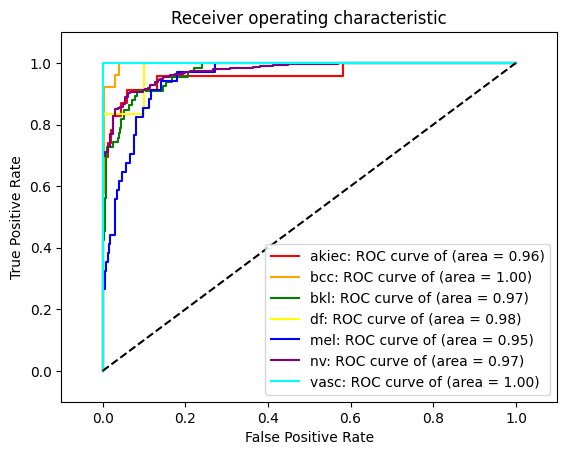

In [43]:

plt.plot(fpr[0], tpr[0],'red',label='akiec: ROC curve of (area = %0.2f)' % roc_auc[0])
plt.plot(fpr[1], tpr[1],'orange',label='bcc: ROC curve of (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[2], tpr[2],'green',label='bkl: ROC curve of (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[3], tpr[3],'yellow',label='df: ROC curve of (area = %0.2f)' % roc_auc[3])
plt.plot(fpr[4], tpr[4],'blue',label='mel: ROC curve of (area = %0.2f)' % roc_auc[4])
plt.plot(fpr[5], tpr[5],'purple',label='nv: ROC curve of (area = %0.2f)' % roc_auc[5])
plt.plot(fpr[6], tpr[6],'aqua',label='vasc: ROC curve of (area = %0.2f)' % roc_auc[6])

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()